In [ ]:
import os, glob, pickle

train_sars = [file for file in glob.glob("../ligand-posing/SARS-CoV-2*") if os.path.isdir(file)]
train_mers = [file for file in glob.glob("../ligand-posing-mers/*") if os.path.isdir(file)]

len(train_sars), len(train_mers)

(770, 44)

## Generate Morgan Fingerprints for all training set fragments

In [2]:
from rdkit import Chem
from rdkit.Chem import Draw, DataStructs, AllChem
import numpy as np

def generate_morgan_fingerprint(mol, radius=4, nBits=256):
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)
    feat = np.zeros((1,), dtype=np.float32)
    DataStructs.ConvertToNumpyArray(fingerprint, feat)
    return feat.astype(np.uint8)

def parse_ligand_info(folder):
    for file in os.listdir(folder):
        if file.endswith(".sdf"):
            mol = Chem.SDMolSupplier(os.path.join(folder, file))
            # Get the first molecule from the SDF file
            if mol and len(mol) > 0:
                mol = mol[0]
                if mol:
                    return Chem.MolFromSmiles(Chem.MolToSmiles(mol))
    return None

def get_ring_and_connected_atoms(molecule):
    """
    Identify ring systems and expand them to include all connected atoms until another ring is encountered.
    """
    if molecule is None:
        return {}
    ring_info = molecule.GetRingInfo()
    ring_atoms = [set(ring) for ring in ring_info.AtomRings()]
    final_ring_atoms = ring_atoms[:]
    for i in range(len(ring_atoms)):
        for j in range(len(ring_atoms)):
            ring1, ring2 = ring_atoms[i], ring_atoms[j]
            if len(ring1.intersection(ring2)) > 0:
                final_ring_atoms[i] = final_ring_atoms[i].union(ring2)
    ring_atoms = list(set(frozenset(s) for s in final_ring_atoms))
    # Create a set of all ring atoms
    all_ring_atoms = set()
    for ring in ring_atoms:
        all_ring_atoms.update(ring)

    # Expand each ring using BFS to include connected atoms until another ring is encountered
    expanded_rings = []
    for ring in ring_atoms:
        expanded_ring = set(ring)
        visited = set(ring)

        # Use a stack for DFS
        stack = list(ring)

        while stack:
            current_atom_idx = stack.pop()
            current_atom = molecule.GetAtomWithIdx(current_atom_idx)

            for neighbor in current_atom.GetNeighbors():
                neighbor_idx = neighbor.GetIdx()
                if neighbor_idx not in visited:
                    visited.add(neighbor_idx)
                    if neighbor_idx not in all_ring_atoms:
                        expanded_ring.add(neighbor_idx)
                        stack.append(neighbor_idx)

        expanded_rings.append(expanded_ring)
    frags = []
    for ring in expanded_rings:
        atom_indices = list(ring)
        # Create an editable molecule
        fragment = Chem.RWMol()
        
        # Create a mapping of original indices to new indices
        idx_map = {}
        
        # First, add all atoms
        for orig_idx in atom_indices:
            orig_atom = molecule.GetAtomWithIdx(orig_idx)
            new_atom = Chem.Atom(orig_atom.GetSymbol())
            # Copy atom properties
            new_atom.SetFormalCharge(orig_atom.GetFormalCharge())
            new_atom.SetNumExplicitHs(orig_atom.GetNumExplicitHs())
            # Add atom and store mapping
            new_idx = fragment.AddAtom(new_atom)
            idx_map[orig_idx] = new_idx
        
        # Then add all bonds between these atoms
        for orig_idx in atom_indices:
            atom = molecule.GetAtomWithIdx(orig_idx)
            for neighbor in atom.GetNeighbors():
                neighbor_idx = neighbor.GetIdx()
                if neighbor_idx in atom_indices and neighbor_idx > orig_idx:
                    bond = molecule.GetBondBetweenAtoms(orig_idx, neighbor_idx)
                    fragment.AddBond(idx_map[orig_idx], 
                                   idx_map[neighbor_idx], 
                                   bond.GetBondType())
        
        try:
            mol_fragment = fragment.GetMol()
            Chem.SanitizeMol(mol_fragment)
            frags.append(mol_fragment)
        except Exception as e:
            print(f"Warning: Could not sanitize fragment: {e}")
            continue
    return {Chem.MolToSmiles(frag): generate_morgan_fingerprint(frag) for frag in frags}

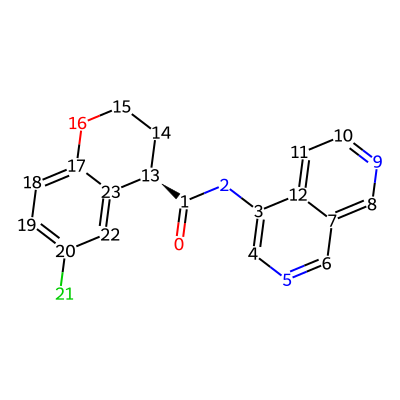


2. Ring indices from GetRingInfo():
Ring 0: [3, 4, 5, 6, 7, 12]
Ring 1: [7, 8, 9, 10, 11, 12]
Ring 2: [13, 14, 15, 16, 17, 23]
Ring 3: [17, 18, 19, 20, 22, 23]

3. All atoms and their details:
Atom 0: O (In Ring: False)
Atom 1: C (In Ring: False)
Atom 2: N (In Ring: False)
Atom 3: C (In Ring: True)
Atom 4: C (In Ring: True)
Atom 5: N (In Ring: True)
Atom 6: C (In Ring: True)
Atom 7: C (In Ring: True)
Atom 8: C (In Ring: True)
Atom 9: N (In Ring: True)
Atom 10: C (In Ring: True)
Atom 11: C (In Ring: True)
Atom 12: C (In Ring: True)
Atom 13: C (In Ring: True)
Atom 14: C (In Ring: True)
Atom 15: C (In Ring: True)
Atom 16: O (In Ring: True)
Atom 17: C (In Ring: True)
Atom 18: C (In Ring: True)
Atom 19: C (In Ring: True)
Atom 20: C (In Ring: True)
Atom 21: Cl (In Ring: False)
Atom 22: C (In Ring: True)
Atom 23: C (In Ring: True)


In [3]:
def draw_mol_with_indices_and_symbols(mol):
    """Draw molecule with both atom indices and symbols visible"""
    for atom in mol.GetAtoms():
        atom.SetProp('atomLabel', str(atom.GetIdx()))
    display(Draw.MolToImage(mol, 
                          size=(400,400), 
                          kekulize=True,
                          wedgeBonds=True))
    print("\n2. Ring indices from GetRingInfo():")
    ring_info = mol.GetRingInfo()
    ring_atoms = [set(ring) for ring in ring_info.AtomRings()]
    for i, ring in enumerate(ring_atoms):
        print(f"Ring {i}: {sorted(ring)}")
    
    print("\n3. All atoms and their details:")
    for atom in mol.GetAtoms():
        idx = atom.GetIdx()
        symbol = atom.GetSymbol()
        is_in_ring = atom.IsInRing()
        print(f"Atom {idx}: {symbol} (In Ring: {is_in_ring})")

mol = parse_ligand_info(train_sars[0])
draw_mol_with_indices_and_symbols(Chem.MolFromSmiles(Chem.MolToSmiles(mol)))


# Extracting Fingerprints for all training set fragments

In [4]:
train_frag_dict_sars = {}
for folder in train_sars:
    folder_name = os.path.basename(folder)
    mol = parse_ligand_info(folder)
    frags = get_ring_and_connected_atoms(mol)
    train_frag_dict_sars[folder_name] = frags

train_frag_dict_mers = {}
for folder in train_mers:
    folder_name = os.path.basename(folder)
    mol = parse_ligand_info(folder)
    frags = get_ring_and_connected_atoms(mol)
    train_frag_dict_mers[folder_name] = frags


sars_test_frag_dict = {}
with open("../TEST_SMILES/sars2_polaris_test.smi", "r") as f:
    for line in f:
        smiles = line.strip()
        frags = get_ring_and_connected_atoms(Chem.MolFromSmiles(smiles))
        sars_test_frag_dict[smiles] = frags
        
mers_test_frag_dict = {}
with open("../TEST_SMILES/mers_polaris_test.smi", "r") as f:
    for line in f:
        smiles = line.strip()
        frags = get_ring_and_connected_atoms(Chem.MolFromSmiles(smiles))
        mers_test_frag_dict[smiles] = frags
        


[22:10:38] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[22:10:38] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 6
[22:10:38] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[22:10:38] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[22:10:38] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[22:10:38] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7


[22:10:38] Can't kekulize mol.  Unkekulized atoms: 3 5 7
[22:10:38] Can't kekulize mol.  Unkekulized atoms: 3 5 7
[22:10:38] Can't kekulize mol.  Unkekulized atoms: 0 3 4 5 6
[22:10:38] Can't kekulize mol.  Unkekulized atoms: 0 3 4 5 6
[22:10:38] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7


[22:10:39] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[22:10:39] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7


[22:10:39] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[22:10:39] Can't kekulize mol.  Unkekulized atoms: 3 4 6
[22:10:40] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7


[22:10:40] Can't kekulize mol.  Unkekulized atoms: 4 5 7
[22:10:40] Can't kekulize mol.  Unkekulized atoms: 3 4 6
[22:10:40] Can't kekulize mol.  Unkekulized atoms: 8 9 11
[22:10:40] Can't kekulize mol.  Unkekulized atoms: 2 6 7


In [6]:
len(train_frag_dict_sars), len(train_frag_dict_mers), len(sars_test_frag_dict), len(mers_test_frag_dict)


(770, 44, 87, 95)

In [7]:
sars_test_frag_dict

{'CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H]2CNc2ccncn2)c2cc(Cl)ccc2C1=O': {'CNC(=O)CN1CC2(C(=O)NCC2CN)c2cc(Cl)ccc2C1=O': array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
         0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
         0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
         0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
         1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
         0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,
         0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

## Generate Ball Tree for training set fragments

In [8]:
from sklearn.neighbors import BallTree
import numpy as np
from collections import defaultdict

def create_fingerprint_balltree(frag_dict):
    # Lists to store fingerprints and their corresponding identifiers
    all_fingerprints = []
    identifiers = []  # Will store (molecule_id, fragment_smiles) pairs
    mapping_pairs = defaultdict(list)
    
    # Flatten the nested dictionary structure
    for mol_id, fragments in frag_dict.items():
        for frag_smiles, fingerprint in fragments.items():
            all_fingerprints.append(fingerprint)
            identifiers.append([mol_id, frag_smiles])
            mapping_pairs[frag_smiles].append(mol_id)
    # Convert to numpy array
    X = np.vstack(all_fingerprints)  # Stack vertically since each fingerprint is already an array
    
    # Create BallTree with Jaccard metric
    tree = BallTree(X, metric='jaccard')
    
    return tree, identifiers, mapping_pairs

def search_similar_fragments(query_fingerprint, tree, identifiers, k=5, similarity_threshold=0.5):
    """
    Search for k most similar fragments to the query fingerprint
    
    Args:
        query_fingerprint: numpy array of the query fingerprint
        tree: BallTree object
        identifiers: list of (molecule_id, smiles) tuples
        k: number of neighbors to return
        similarity_threshold: minimum similarity score to include in results
    """
    # Reshape query to 2D array
    query = query_fingerprint.reshape(1, -1)
    
    # Find k nearest neighbors
    distances, indices = tree.query(query, k=k)
    
    # Get the corresponding identifiers
    results = []
    for dist, idx in zip(distances[0], indices[0]):
        similarity = 1 - dist  # Convert distance to similarity
        if similarity >= similarity_threshold:
            mol_id, frag_smiles = identifiers[idx]
            results.append({
                'molecule_id': mol_id,
                'fragment_smiles': frag_smiles,
                'similarity': similarity
            })
    
    return results

In [9]:
train_tree, train_identifiers, train_mapping = create_fingerprint_balltree(train_frag_dict_sars)

train_tree_mers, train_identifiers_mers, train_mapping_mers = create_fingerprint_balltree(train_frag_dict_mers)

In [10]:
def query_similar_fragments(test_frag_dict, train_tree, train_identifiers, k=5, similarity_threshold=0.2):
    """
    Query similar fragments from training set for each fragment in test set
    
    Args:
        test_frag_dict: dictionary of test fragments
        train_tree: BallTree created from training fragments
        train_identifiers: list of (molecule_id, smiles) tuples for training data
        k: number of neighbors to return
        similarity_threshold: minimum similarity score to include
    """
    results = {}
    
    for test_mol_id, test_fragments in test_frag_dict.items():
        mol_results = {}
        for test_frag_smiles, test_fingerprint in test_fragments.items():
            # Search for similar fragments
            similar_frags = search_similar_fragments(
                test_fingerprint, 
                train_tree, 
                train_identifiers, 
                k=k, 
                similarity_threshold=similarity_threshold
            )
            
            # Store results
            mol_results[test_frag_smiles] = similar_frags
        
        results[test_mol_id] = mol_results
    
    return results

def visualize_similar_fragments(results, n_examples=3):
    """
    Visualize the similar fragments found
    """
    for i, (test_mol_id, fragments) in enumerate(results.items()):
        if i >= n_examples:  # Limit number of examples shown
            break
            
        print(f"\nTest Molecule: {test_mol_id}")
        for test_frag_smiles, similar_frags in fragments.items():
            print(f"\nQuery Fragment: {test_frag_smiles}")
            
            # Draw query fragment
            query_mol = Chem.MolFromSmiles(test_frag_smiles)
            display(Draw.MolToImage(query_mol))
            
            print("\nTop similar fragments:")
            for match in similar_frags:
                print(f"Molecule: {match['molecule_id']}")
                print(f"Fragment: {match['fragment_smiles']}")
                print(f"Similarity: {match['similarity']:.3f}")
                
                # Draw similar fragment
                similar_mol = Chem.MolFromSmiles(match['fragment_smiles'])
                display(Draw.MolToImage(similar_mol))
                print("-" * 50)

# Run the query
sars_test_similar_fragments = query_similar_fragments(
    sars_test_frag_dict, 
    train_tree, 
    train_identifiers, 
    k=5, 
    similarity_threshold=0.6
)

mers_test_similar_fragments = query_similar_fragments(
    mers_test_frag_dict, 
    train_tree, 
    train_identifiers, 
    k=5, 
    similarity_threshold=0.6
)

# Visualize results
# visualize_similar_fragments(similar_fragments, n_examples=2)

In [11]:
sars_test_smiles_path = "../TEST_SMILES/sars2_polaris_test.smi"
mers_test_smiles_path = "../TEST_SMILES/mers_polaris_test.smi"

sars_test_smiles_mapping = defaultdict(list)
mers_test_smiles_mapping = defaultdict(list)

for i, smiles in enumerate(open(sars_test_smiles_path, "r").readlines()):
    smiles = smiles.strip()
    sars_test_smiles_mapping[smiles].append(f"lig{i+1}")

for i, smiles in enumerate(open(mers_test_smiles_path, "r").readlines()):
    smiles = smiles.strip()
    mers_test_smiles_mapping[smiles].append(f"lig{i+1}")

## Generate Candidates based on MCS

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdFMCS import FindMCS

def find_mcs(smiles_1, smiles_2):
    mol_1 = Chem.MolFromSmiles(smiles_1)
    mol_2 = Chem.MolFromSmiles(smiles_2)
    mcs_result = FindMCS([mol_1, mol_2])
    return mcs_result.smartsString

def generate_constrained_conformers(mol_to_align, ref_mol, mcs_smarts, n_conformers=10):
    """
    Rapidly generate multiple conformers while maintaining core constraint
    """
    # Get atom mapping indices from MCS
    mcs_mol = Chem.MolFromSmarts(mcs_smarts)
    ref_match = ref_mol.GetSubstructMatch(mcs_mol)
    align_match = mol_to_align.GetSubstructMatch(mcs_mol)
    
    if not ref_match or not align_match:
        raise ValueError("MCS matching failed.")
    
    # Create coordinate map from reference structure
    match_map = list(zip(ref_match, align_match))
    coordMap = {}

    for ref_idx, align_idx in match_map:
        ref_pos = ref_mol.GetConformer().GetAtomPosition(ref_idx)
        coordMap[align_idx] = ref_pos
    
    # Generate multiple conformers with coordinate constraints
    cids = AllChem.EmbedMultipleConfs(
        mol_to_align,
        numConfs=n_conformers,
        coordMap=coordMap,
        randomSeed=42,
        numThreads=0  # Use all available threads
    )
    
    if len(cids) == 0:
        raise ValueError("Failed to generate any conformers")
    
    # Minimize each conformer with constraints
    results = []
    for cid in cids:
        # # Create force field
        # ff = AllChem.MMFFGetMoleculeForceField(
        #     mol_to_align,
        #     AllChem.MMFFGetMoleculeProperties(mol_to_align),
        #     confId=cid
        # )
        
        # # Add positional constraints for mapped atoms
        # for align_idx in align_match:
        #     ff.AddFixedPoint(align_idx)
        
        # try:
        #     # Minimize with constraints
        #     ff.Minimize(maxIts=200)
        #     energy = ff.CalcEnergy()
        # except Exception as e:
        #     print(f"Minimization failed for conformer {cid}: {e}")
        #     continue
        
        # Align molecule and save the aligned coordinates to the current conformer
        rmsd = AllChem.AlignMol(mol_to_align, ref_mol, atomMap = list(zip(align_match, ref_match)), prbCid=cid)

        results.append((cid, rmsd))
    # Sort by energy
    results.sort(key=lambda x: x[1])
    
    return mol_to_align, results

def align_smiles_to_sdf(smiles: str, sdf_path: str, mcs_smarts: str, save_folder: str, n_conformers=10, save_name=None):
    """
    Aligns a molecule and generates multiple conformers
    """
    # Load reference molecule
    ref_supplier = Chem.SDMolSupplier(sdf_path)
    ref_mol = ref_supplier[0]
    
    if ref_mol is None:
        raise ValueError("Failed to read reference molecule from SDF.")

    # Convert input SMILES
    mol_to_align = Chem.MolFromSmiles(smiles)
    if mol_to_align is None:
        raise ValueError("Invalid SMILES string.")

    # Add hydrogens
    ref_mol = Chem.AddHs(ref_mol)
    mol_to_align = Chem.AddHs(mol_to_align)
    
    # Generate conformers
    mol_with_confs, results = generate_constrained_conformers(
        mol_to_align,
        ref_mol,
        mcs_smarts,
        n_conformers=n_conformers
    )
    
    # Save conformers
    for i, (conf_id, rmsd) in enumerate(results):
        save_path = os.path.join(save_folder, f"{save_name}_conf{i}.sdf")
        writer = Chem.SDWriter(save_path)
        
        # Create a new molecule with just this conformer
        conf_mol = Chem.Mol(mol_with_confs)
        conf_mol.RemoveAllConformers()
        conf_mol.AddConformer(mol_with_confs.GetConformer(conf_id))
        
        # Add properties
        conf_mol.SetProp('RMSD', str(rmsd))
        conf_mol.SetProp('ConfId', str(i))
        
        writer.write(conf_mol)
        writer.close()
    
    return mol_with_confs

In [14]:
# generate n candidates for each test fragment for sars_test_similar_fragments
import shutil, os, json
from tqdm import tqdm

os.makedirs("frag-results-sars-test", exist_ok=True)
sars_path = "../ligand-posing"
mers_path = "../ligand-posing-mers"

for sars_test_smiles, frags in tqdm(sars_test_similar_fragments.items()):
    name = sars_test_smiles_mapping[sars_test_smiles][0]
    shutil.rmtree(os.path.join("frag-results-sars-test", name), ignore_errors=True)
    os.makedirs(os.path.join("frag-results-sars-test", name, "candidate_ligands"), exist_ok=True)
    frag_info = defaultdict(list)
    for i, (frag_smiles, similar_list) in enumerate(frags.items()):
        for j, similar_info in enumerate(similar_list[:5]):
            to_align_smiles = similar_info["fragment_smiles"]
            similarity = similar_info["similarity"]
            molecule_id = similar_info["molecule_id"]
            mcs_smarts = find_mcs(frag_smiles, to_align_smiles)
            frag_info[molecule_id].append({'original_frag': to_align_smiles, "target_frag": frag_smiles, 'similarity': similarity, 'mcs_smarts': mcs_smarts})
            raw_pdb_folder = os.path.join(sars_path, similar_info["molecule_id"])
            raw_pdb_name = os.path.basename(raw_pdb_folder)
            raw_pdb_file = os.path.join(raw_pdb_folder, "protein_aligned.pdb")
            raw_sdf_file = os.path.join(raw_pdb_folder, "ligand_aligned_final.sdf")
            shutil.copy(raw_pdb_file, os.path.join("frag-results-sars-test", name, f"{raw_pdb_name}_protein.pdb"))
            try:
                align_smiles_to_sdf(sars_test_smiles, raw_sdf_file, mcs_smarts, os.path.join("frag-results-sars-test", name, "candidate_ligands"), save_name = f"{raw_pdb_name}_frag{i}")
                shutil.copy(raw_sdf_file, os.path.join("frag-results-sars-test", name, f"{raw_pdb_name}_ligand.sdf"))
            except Exception as e:
                print(f"Error aligning {name} {sars_test_smiles} to {raw_sdf_file}: {e}")
    # save frag_info
    with open(os.path.join("frag-results-sars-test", name, f"frag_info.json"), "w") as f:
        json.dump(frag_info, f)
    with open(os.path.join("frag-results-sars-test", name, f"ligand_smiles.smi"), "w") as f:
        f.write(sars_test_smiles)
    
    if len(sars_test_smiles_mapping[sars_test_smiles]) > 1:
        for i, lig_name in enumerate(sars_test_smiles_mapping[sars_test_smiles]):
            if lig_name == name:
                continue
            else:
                shutil.rmtree(os.path.join("frag-results-sars-test", lig_name), ignore_errors=True)
                shutil.copytree(os.path.join("frag-results-sars-test", name), os.path.join("frag-results-sars-test", lig_name))

 25%|██▌       | 22/87 [00:29<01:52,  1.73s/it]

Error aligning lig23 O=C1N[C@@]2(CCOc3ccncc32)C(=O)N1c1cncc2ccccc12 to /pscratch/sd/k/kysun/polaris/ligand-posing/SARS-CoV-2_Mpro-P0022_0A_CONFIDENTIAL/ligand_aligned_final.sdf: MCS matching failed.
Error aligning lig23 O=C1N[C@@]2(CCOc3ccncc32)C(=O)N1c1cncc2ccccc12 to /pscratch/sd/k/kysun/polaris/ligand-posing/SARS-CoV-2_Mpro-P0022_0B_CONFIDENTIAL/ligand_aligned_final.sdf: MCS matching failed.
Error aligning lig23 O=C1N[C@@]2(CCOc3ccncc32)C(=O)N1c1cncc2ccccc12 to /pscratch/sd/k/kysun/polaris/ligand-posing/SARS-CoV-2_Mpro-P0143_0A_CONFIDENTIAL/ligand_aligned_final.sdf: MCS matching failed.
Error aligning lig23 O=C1N[C@@]2(CCOc3ccncc32)C(=O)N1c1cncc2ccccc12 to /pscratch/sd/k/kysun/polaris/ligand-posing/SARS-CoV-2_Mpro-P0143_0B_CONFIDENTIAL/ligand_aligned_final.sdf: MCS matching failed.
Error aligning lig23 O=C1N[C@@]2(CCOc3ccncc32)C(=O)N1c1cncc2ccccc12 to /pscratch/sd/k/kysun/polaris/ligand-posing/SARS-CoV-2_Mpro-x12686_0A_CONFIDENTIAL/ligand_aligned_final.sdf: MCS matching failed.


 28%|██▊       | 24/87 [00:31<01:32,  1.47s/it]

Error aligning lig25 O=C(C[N@H+]1Cc2ccc(Cl)cc2[C@@]2(CCN(c3cncc4ccccc34)C2=O)C1)NC[C@H]1C[C@@H](F)C1 to /pscratch/sd/k/kysun/polaris/ligand-posing/SARS-CoV-2_Mpro-P2730_0A_CONFIDENTIAL/ligand_aligned_final.sdf: MCS matching failed.
Error aligning lig25 O=C(C[N@H+]1Cc2ccc(Cl)cc2[C@@]2(CCN(c3cncc4ccccc34)C2=O)C1)NC[C@H]1C[C@@H](F)C1 to /pscratch/sd/k/kysun/polaris/ligand-posing/SARS-CoV-2_Mpro-P2607_0B_CONFIDENTIAL/ligand_aligned_final.sdf: MCS matching failed.
Error aligning lig25 O=C(C[N@H+]1Cc2ccc(Cl)cc2[C@@]2(CCN(c3cncc4ccccc34)C2=O)C1)NC[C@H]1C[C@@H](F)C1 to /pscratch/sd/k/kysun/polaris/ligand-posing/SARS-CoV-2_Mpro-P2607_0A_CONFIDENTIAL/ligand_aligned_final.sdf: MCS matching failed.
Error aligning lig25 O=C(C[N@H+]1Cc2ccc(Cl)cc2[C@@]2(CCN(c3cncc4ccccc34)C2=O)C1)NC[C@H]1C[C@@H](F)C1 to /pscratch/sd/k/kysun/polaris/ligand-posing/SARS-CoV-2_Mpro-P2730_0B_CONFIDENTIAL/ligand_aligned_final.sdf: MCS matching failed.
Error aligning lig25 O=C(C[N@H+]1Cc2ccc(Cl)cc2[C@@]2(CCN(c3cncc4ccccc34)

 36%|███▌      | 31/87 [00:44<01:06,  1.18s/it][22:13:34] Could not triangle bounds smooth molecule.


Error aligning lig37 O=C(Cc1cncc2ccccc12)N1CCCC[C@H]1c1ccccc1 to /pscratch/sd/k/kysun/polaris/ligand-posing/SARS-CoV-2_Mpro-x10488_0A_CONFIDENTIAL/ligand_aligned_final.sdf: Failed to generate any conformers


 64%|██████▍   | 56/87 [01:13<00:32,  1.06s/it][22:14:04] Could not triangle bounds smooth molecule.


Error aligning lig63 O=C(Cc1cncc2ccccc12)N1CCC(C2CC2)CC1 to /pscratch/sd/k/kysun/polaris/ligand-posing/SARS-CoV-2_Mpro-x10488_0A_CONFIDENTIAL/ligand_aligned_final.sdf: Failed to generate any conformers


 89%|████████▊ | 77/87 [01:29<00:06,  1.49it/s]

Error aligning lig84 NS(=O)(=O)c1ccc2c(c1)[C@@]1(CCO2)NC(=O)N(c2cncc3ccccc23)C1=O to /pscratch/sd/k/kysun/polaris/ligand-posing/SARS-CoV-2_Mpro-P0022_0A_CONFIDENTIAL/ligand_aligned_final.sdf: MCS matching failed.
Error aligning lig84 NS(=O)(=O)c1ccc2c(c1)[C@@]1(CCO2)NC(=O)N(c2cncc3ccccc23)C1=O to /pscratch/sd/k/kysun/polaris/ligand-posing/SARS-CoV-2_Mpro-P0022_0B_CONFIDENTIAL/ligand_aligned_final.sdf: MCS matching failed.
Error aligning lig84 NS(=O)(=O)c1ccc2c(c1)[C@@]1(CCO2)NC(=O)N(c2cncc3ccccc23)C1=O to /pscratch/sd/k/kysun/polaris/ligand-posing/SARS-CoV-2_Mpro-P0143_0A_CONFIDENTIAL/ligand_aligned_final.sdf: MCS matching failed.
Error aligning lig84 NS(=O)(=O)c1ccc2c(c1)[C@@]1(CCO2)NC(=O)N(c2cncc3ccccc23)C1=O to /pscratch/sd/k/kysun/polaris/ligand-posing/SARS-CoV-2_Mpro-P0143_0B_CONFIDENTIAL/ligand_aligned_final.sdf: MCS matching failed.
Error aligning lig84 NS(=O)(=O)c1ccc2c(c1)[C@@]1(CCO2)NC(=O)N(c2cncc3ccccc23)C1=O to /pscratch/sd/k/kysun/polaris/ligand-posing/SARS-CoV-2_Mpro-x126

100%|██████████| 87/87 [01:36<00:00,  1.11s/it]


In [16]:
# generate n candidates for each test fragment for mers_test_similar_fragments
import shutil, os, json
from tqdm import tqdm

os.makedirs("frag-results-mers-test", exist_ok=True)
sars_path = "../ligand-posing"
mers_path = "../ligand-posing-mers"

for mers_test_smiles, frags in tqdm(mers_test_similar_fragments.items()):
    name = mers_test_smiles_mapping[mers_test_smiles][0]
    shutil.rmtree(os.path.join("frag-results-mers-test", name), ignore_errors=True)
    os.makedirs(os.path.join("frag-results-mers-test", name, "candidate_ligands"), exist_ok=True)
    frag_info = defaultdict(list)
    for i, (frag_smiles, similar_list) in enumerate(frags.items()):
        for j, similar_info in enumerate(similar_list[:5]):
            to_align_smiles = similar_info["fragment_smiles"]
            similarity = similar_info["similarity"]
            molecule_id = similar_info["molecule_id"]
            mcs_smarts = find_mcs(frag_smiles, to_align_smiles)
            frag_info[molecule_id].append({'original_frag': to_align_smiles, "target_frag": frag_smiles, 'similarity': similarity, 'mcs_smarts': mcs_smarts})
            raw_pdb_folder = os.path.join(sars_path, similar_info["molecule_id"])
            raw_pdb_name = os.path.basename(raw_pdb_folder)
            raw_pdb_file = os.path.join(raw_pdb_folder, "protein_aligned_mers.pdb")
            raw_sdf_file = os.path.join(raw_pdb_folder, "ligand_aligned_mers_final.sdf")
            shutil.copy(raw_pdb_file, os.path.join("frag-results-mers-test", name, f"{raw_pdb_name}_protein.pdb"))
            try:
                align_smiles_to_sdf(mers_test_smiles, raw_sdf_file, mcs_smarts, os.path.join("frag-results-mers-test", name, "candidate_ligands"), save_name = f"{raw_pdb_name}_frag{i}")
                shutil.copy(raw_sdf_file, os.path.join("frag-results-mers-test", name, f"{raw_pdb_name}_ligand.sdf"))
            except Exception as e:
                print(f"Error aligning {name} {mers_test_smiles} to {raw_sdf_file}: {e}")
    # save frag_info
    with open(os.path.join("frag-results-mers-test", name, f"frag_info.json"), "w") as f:
        json.dump(frag_info, f)
    with open(os.path.join("frag-results-mers-test", name, f"ligand_smiles.smi"), "w") as f:
        f.write(mers_test_smiles)
    
    if len(mers_test_smiles_mapping[mers_test_smiles]) > 1:
        for i, lig_name in enumerate(mers_test_smiles_mapping[mers_test_smiles]):
            if lig_name == name:
                continue
            else:
                shutil.rmtree(os.path.join("frag-results-mers-test", lig_name), ignore_errors=True)
                shutil.copytree(os.path.join("frag-results-mers-test", name), os.path.join("frag-results-mers-test", lig_name))

  8%|▊         | 8/95 [00:08<01:39,  1.15s/it]

Error aligning lig8 O=C(Cc1cncc2ccccc12)N1CCCCC1 to /pscratch/sd/k/kysun/polaris/ligand-posing/SARS-CoV-2_Mpro-x10488_0A_CONFIDENTIAL/ligand_aligned_mers_final.sdf: Failed to generate any conformers


 17%|█▋        | 16/95 [00:15<01:14,  1.06it/s]

Error aligning lig17 C[C@H]1C[C@H](c2ccccc2)N(C(=O)Cc2cncc3ccccc23)C1 to /pscratch/sd/k/kysun/polaris/ligand-posing/SARS-CoV-2_Mpro-x12204_0A_CONFIDENTIAL/ligand_aligned_mers_final.sdf: Failed to generate any conformers
Error aligning lig17 C[C@H]1C[C@H](c2ccccc2)N(C(=O)Cc2cncc3ccccc23)C1 to /pscratch/sd/k/kysun/polaris/ligand-posing/SARS-CoV-2_Mpro-z7b2j_0A_CONFIDENTIAL/ligand_aligned_mers_final.sdf: Failed to generate any conformers


100%|██████████| 95/95 [02:12<00:00,  1.40s/it]


## Transfer Crossdocked Results

In [3]:
# transfer mcsce crossdocked_results
import shutil, os, json, glob
from tqdm import tqdm

def split_sdf(sdf_path, save_name):
    with open(sdf_path, "r") as f:
        lines = f.readlines()
    ligand_lines = []
    i = 1
    for line in lines:
        if line.strip() == "$$$$":
            ligand_lines.append(line)
            with open(f"{save_name}_conf{i}.sdf", "w") as f:
                for line in ligand_lines:
                    f.write(line)
            ligand_lines = []
            i += 1
        else:
            ligand_lines.append(line)

for vina_dir in glob.glob("/pscratch/sd/k/kysun/polaris/frag_docking_combined/vina-results-mcsce/*"):
    name = os.path.basename(vina_dir)
    if "mers_test" in name:
        protein_name = name.replace("_mers_test", "")
        for lig_path in tqdm(glob.glob(os.path.join(vina_dir, "*.sdf"))):
            lig_name = lig_path.replace("_in_out.sdf", "").split("_")[-1]
            split_sdf(lig_path, os.path.join("frag-results-mers-test", lig_name, "candidate_ligands", f"{protein_name}_docked_mcsce"))
    elif "sars_test" in name:
        protein_name = name.replace("_sars_test", "")
        for lig_path in tqdm(glob.glob(os.path.join(vina_dir, "*.sdf"))):
            lig_name = lig_path.replace("_in_out.sdf", "").split("_")[-1]
            split_sdf(lig_path, os.path.join("frag-results-sars-test", lig_name, "candidate_ligands", f"{protein_name}_docked_mcsce"))
    # elif "sars_train" in name:
    #     protein_name = name.replace("_sars_train", "")
    #     for lig_path in tqdm(glob.glob(os.path.join(vina_dir, "*.sdf"))):
    #         lig_name = lig_path.replace("_in_out.sdf", "").split("_")[-1]
    #         split_sdf(lig_path, os.path.join("frag-results-sars-train", lig_name, "candidate_ligands", f"{protein_name}_docked_mcsce"))

100%|██████████| 98/98 [00:00<00:00, 98.14it/s]


In [ ]:
# transfer crystal crossdocked_results
import shutil, os, json
from tqdm import tqdm

def split_sdf(sdf_path, save_name):
    with open(sdf_path, "r") as f:
        lines = f.readlines()
    ligand_lines = []
    i = 1
    for line in lines:
        if line.strip() == "$$$$":
            ligand_lines.append(line)
            with open(f"{save_name}_conf{i}.sdf", "w") as f:
                for line in ligand_lines:
                    f.write(line)
            ligand_lines = []
            i += 1
        else:
            ligand_lines.append(line)

for vina_dir in glob.glob("/pscratch/sd/k/kysun/polaris/frag_docking_combined/vina-results-xtal/*"):
    name = os.path.basename(vina_dir)
    if "mers_test" in name:
        protein_name = name.replace("_mers_test", "")
        for lig_path in tqdm(glob.glob(os.path.join(vina_dir, "*.sdf"))):
            lig_name = lig_path.replace("_in_out.sdf", "").split("_")[-1]
            split_sdf(lig_path, os.path.join("frag-results-mers-test", lig_name, "candidate_ligands", f"{protein_name}_docked_xtal"))
    elif "sars_test" in name:
        protein_name = name.replace("_sars_test", "")
        for lig_path in tqdm(glob.glob(os.path.join(vina_dir, "*.sdf"))):
            lig_name = lig_path.replace("_in_out.sdf", "").split("_")[-1]
            split_sdf(lig_path, os.path.join("frag-results-sars-test", lig_name, "candidate_ligands", f"{protein_name}_docked_xtal"))
    elif "sars_train" in name:
        protein_name = name.replace("_sars_train", "")
        for lig_path in tqdm(glob.glob(os.path.join(vina_dir, "*.sdf"))):
            lig_name = lig_path.replace("_in_out.sdf", "").split("_")[-1]
            split_sdf(lig_path, os.path.join("frag-results-sars-train", lig_name, "candidate_ligands", f"{protein_name}_docked_xtal"))

## Prepare for docking with fragments

after preparation, the folder will be sent to the docking notebook for docking

In [4]:
os.makedirs("vina-prep-frag", exist_ok=True)

for folder in tqdm(glob.glob("frag-results*/lig*")):
    if os.path.isdir(folder):
        lig_name = os.path.basename(folder)
        protein_name = folder.split("/")[0].replace("frag-results-", "")
        ligand_smiles = os.path.join(folder, "ligand_smiles.smi")
        proteins = glob.glob(os.path.join(folder, "*.pdb"))
        os.makedirs(os.path.join("vina-prep-frag", f"{protein_name}_{lig_name}"), exist_ok=True)
        for protein in proteins:
            shutil.copy(protein, os.path.join("vina-prep-frag", f"{protein_name}_{lig_name}"))
        shutil.copy(ligand_smiles, os.path.join("vina-prep-frag", f"{protein_name}_{lig_name}"))
    

100%|██████████| 265/265 [00:04<00:00, 56.54it/s]


In [ ]:
# transfer docking on proteins with fragments similar to test fragments
import shutil, os, json, glob
from tqdm import tqdm

def split_sdf(sdf_path, save_name):
    with open(sdf_path, "r") as f:
        lines = f.readlines()
    ligand_lines = []
    i = 1
    for line in lines:
        if line.strip() == "$$$$":
            ligand_lines.append(line)
            with open(f"{save_name}_conf{i}.sdf", "w") as f:
                for line in ligand_lines:
                    f.write(line)
            ligand_lines = []
            i += 1
        else:
            ligand_lines.append(line)

for vina_dir in glob.glob("/pscratch/sd/k/kysun/polaris/frag_docking_combined/vina-results-frag/*"):
    name = os.path.basename(vina_dir)
    if "mers-test" in name:
        for lig_path in tqdm(glob.glob(os.path.join(vina_dir, "*", "*.sdf"))):
            lig_name = lig_path.split("/")[-2]
            protein_name = lig_path.split("/")[-1].replace("_docked.sdf", "")
            split_sdf(lig_path, os.path.join("frag-results-mers-test", lig_name, "candidate_ligands", f"{protein_name}_docked_frag"))
    elif "sars-test" in name:
        for lig_path in tqdm(glob.glob(os.path.join(vina_dir, "*", "*.sdf"))):
            lig_name = lig_path.split("/")[-2]
            protein_name = lig_path.split("/")[-1].replace("_docked.sdf", "")
            split_sdf(lig_path, os.path.join("frag-results-sars-test", lig_name, "candidate_ligands", f"{protein_name}_docked_frag"))
    elif "sars-train" in name:
        for lig_path in tqdm(glob.glob(os.path.join(vina_dir, "*", "*.sdf"))):
            lig_name = lig_path.split("/")[-2]
            protein_name = lig_path.split("/")[-1].replace("_docked.sdf", "")
            split_sdf(lig_path, os.path.join("frag-results-sars-train", lig_name, "candidate_ligands", f"{protein_name}_docked_frag"))

## Enhanced Sampling

In [3]:
import shutil, os, json, glob, pickle
import numpy as np
from tqdm import tqdm
from rdkit import Chem

sars_test_prediction_folder = "/pscratch/sd/k/kysun/polaris/frag_docking_combined/frag-results-sars-test"
frag_score_dict = pickle.load(open("frag_score_dict_sars_test.pkl", "rb"))
ligs_to_search = [k for k, v in frag_score_dict.items() if v is not None and np.min(list(v.values())) > 10]

for lig in ligs_to_search:
    os.makedirs(os.path.join(sars_test_prediction_folder, lig, "candidate_ligands_enhanced"), exist_ok=True)
    sample_ligand = glob.glob(os.path.join(sars_test_prediction_folder, lig, "candidate_ligands", "*.sdf"))[0]
    sample_smiles = Chem.MolToSmiles(Chem.SDMolSupplier(sample_ligand)[0])
    crystal_ligands = glob.glob(os.path.join(sars_test_prediction_folder, lig, "*.sdf"))
    for ligand in crystal_ligands:
        try:
            crystal_smiles = Chem.MolToSmiles(Chem.SDMolSupplier(ligand)[0])
            mcs_smarts = find_mcs(sample_smiles, crystal_smiles)
            align_smiles_to_sdf(sample_smiles, ligand, mcs_smarts, os.path.join(sars_test_prediction_folder, lig, "candidate_ligands_enhanced"), save_name = os.path.basename(ligand))
        except Exception as e:
            print(f"Error aligning {lig} {crystal_smiles} to {sample_smiles}: {e}")

[02:51:55] Could not triangle bounds smooth molecule.


Error aligning lig26 CC(=O)Nc1cccc(N2CCCC2=O)c1 to O=C(C[N@H+]1Cc2ccc(Cl)cc2[C@H](C(=O)Nc2cncc3ccccc23)C1)Nc1ccc(N2CCOCC2=O)cc1: Failed to generate any conformers


[02:51:56] Could not triangle bounds smooth molecule.


Error aligning lig26 O=C(Cc1cncc2ccccc12)Nc1ccccc1 to O=C(C[N@H+]1Cc2ccc(Cl)cc2[C@H](C(=O)Nc2cncc3ccccc23)C1)Nc1ccc(N2CCOCC2=O)cc1: Failed to generate any conformers


[02:51:58] Could not triangle bounds smooth molecule.


Error aligning lig26 CC(=O)N(c1ccccc1)[C@H]1CCS(=O)(=O)C1 to O=C(C[N@H+]1Cc2ccc(Cl)cc2[C@H](C(=O)Nc2cncc3ccccc23)C1)Nc1ccc(N2CCOCC2=O)cc1: Failed to generate any conformers


[02:51:59] Could not triangle bounds smooth molecule.
[02:51:59] Could not triangle bounds smooth molecule.
[02:51:59] Could not triangle bounds smooth molecule.


Error aligning lig37 O=C1N[C@]2(C[C@@H](c3ccccc3)C2)C(=O)N1c1cncc2ccccc12 to O=C(Cc1cncc2ccccc12)N1CCCC[C@H]1c1ccccc1: Failed to generate any conformers
Error aligning lig37 CC(=O)N1CCC[C@@H](c2nc3ccccc3s2)C1 to O=C(Cc1cncc2ccccc12)N1CCCC[C@H]1c1ccccc1: Failed to generate any conformers
Error aligning lig37 NC(=O)[C@@H]1C[N@@H+](Cc2cccnc2)C[C@H]1c1ccccc1 to O=C(Cc1cncc2ccccc12)N1CCCC[C@H]1c1ccccc1: Failed to generate any conformers


[02:51:59] Could not triangle bounds smooth molecule.


Error aligning lig37 O=C(C[C@@]1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21)N1CCCC[C@@H]1c1cn[nH]c1 to O=C(Cc1cncc2ccccc12)N1CCCC[C@H]1c1ccccc1: Failed to generate any conformers
Error aligning lig77 O=C1[C@H](c2cccc(Cl)c2)CCCN1c1cncc2ccccc12 to C[C@H]1CN(c2cncc3ccccc23)C(=O)[C@@]12CN(CC[NH+]1CCOCC1)C(=O)c1ccc(Cl)cc12: Failed to generate any conformers


[02:52:55] Could not triangle bounds smooth molecule.
[02:52:55] Could not triangle bounds smooth molecule.


Error aligning lig74 CC(=O)N1Cc2ccccc2[C@@H](c2cccc(C)c2)C1 to O=C(Cc1cncc2ccccc12)N1CCCC[C@H]1Cc1ccccc1: Failed to generate any conformers
Error aligning lig74 O=C(C[C@@]1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21)N1CCC[C@@H]1Cn1ccnc1 to O=C(Cc1cncc2ccccc12)N1CCCC[C@H]1Cc1ccccc1: Failed to generate any conformers


[02:52:55] Could not triangle bounds smooth molecule.
[02:52:56] Could not triangle bounds smooth molecule.


Error aligning lig74 CC(=O)N1Cc2ccccc2[C@@H](c2cccc(C)c2)C1 to O=C(Cc1cncc2ccccc12)N1CCCC[C@H]1Cc1ccccc1: Failed to generate any conformers
Error aligning lig55 OC[C@H]1CN(Cc2ccccc2)CCO1 to Cn1c(Cc2ccccc2)nn(-c2cncc3ccccc23)c1=O: Failed to generate any conformers


[02:52:56] Could not triangle bounds smooth molecule.


Error aligning lig55 O=C(Nc1cccnc1)NC1(Cc2ccccc2)CCOCC1 to Cn1c(Cc2ccccc2)nn(-c2cncc3ccccc23)c1=O: Failed to generate any conformers


[02:52:56] Could not triangle bounds smooth molecule.
[02:52:56] Could not triangle bounds smooth molecule.


Error aligning lig75 O=C1[C@H](c2cccc(Cl)c2)CCN1c1cncc2ccccc12 to O=C1N[C@]2(C[C@H](c3ccccc3Cl)C2)C(=O)N1c1cncc2ccccc12: Failed to generate any conformers
Error aligning lig75 O=C1N[C@]2(C[C@H](C3CCC3)C2)C(=O)N1c1cncc2ccccc12 to O=C1N[C@]2(C[C@H](c3ccccc3Cl)C2)C(=O)N1c1cncc2ccccc12: Failed to generate any conformers
Error aligning lig75 O=C1N[C@]2(C[C@@H](c3ccccc3)C2)C(=O)N1c1cncc2ccccc12 to O=C1N[C@]2(C[C@H](c3ccccc3Cl)C2)C(=O)N1c1cncc2ccccc12: Failed to generate any conformers
Error aligning lig75 O=C1[C@H](c2cccc(Cl)c2)CCCN1c1cncc2ccccc12 to O=C1N[C@]2(C[C@H](c3ccccc3Cl)C2)C(=O)N1c1cncc2ccccc12: Failed to generate any conformers
Error aligning lig75 CNC(=O)C[N@H+]1Cc2ccc(Cl)cc2[C@@]2(CC(=O)N(c3cncc4ccccc34)C2=O)C1 to O=C1N[C@]2(C[C@H](c3ccccc3Cl)C2)C(=O)N1c1cncc2ccccc12: Failed to generate any conformers


[02:53:03] Could not triangle bounds smooth molecule.
[02:53:03] Could not triangle bounds smooth molecule.
[02:53:03] Could not triangle bounds smooth molecule.
[02:53:03] Could not triangle bounds smooth molecule.


Error aligning lig75 O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(c2cccc(Cl)c2)C(=O)C1 to O=C1N[C@]2(C[C@H](c3ccccc3Cl)C2)C(=O)N1c1cncc2ccccc12: Failed to generate any conformers
Error aligning lig75 O=C1N(c2cncc3ccccc23)CC[C@@]1(O)c1cccc(Cl)c1 to O=C1N[C@]2(C[C@H](c3ccccc3Cl)C2)C(=O)N1c1cncc2ccccc12: Failed to generate any conformers
Error aligning lig75 O=C(C[N@H+]1Cc2ccc(Cl)cc2[C@@]2(CCN(c3cncc4ccccc34)C2=O)C1)NCC1CC1 to O=C1N[C@]2(C[C@H](c3ccccc3Cl)C2)C(=O)N1c1cncc2ccccc12: Failed to generate any conformers


[02:53:03] Could not triangle bounds smooth molecule.
[02:53:04] Could not triangle bounds smooth molecule.
[02:53:04] Could not triangle bounds smooth molecule.
[02:53:04] Could not triangle bounds smooth molecule.
[02:53:04] Could not triangle bounds smooth molecule.
[02:53:04] Could not triangle bounds smooth molecule.


Error aligning lig75 CNC(=O)C1(N2C[C@]3(CCN(c4cncc5ccccc45)C3=O)c3cc(Cl)ccc3C2=O)CC1 to O=C1N[C@]2(C[C@H](c3ccccc3Cl)C2)C(=O)N1c1cncc2ccccc12: Failed to generate any conformers
Error aligning lig75 O=C1N[C@]2(C[C@H](C3CCC3)C2)C(=O)N1c1cncc(F)c1 to O=C1N[C@]2(C[C@H](c3ccccc3Cl)C2)C(=O)N1c1cncc2ccccc12: Failed to generate any conformers
Error aligning lig75 O=C1N[C@]2(C[C@H](C3CCC3)C2)C(=O)N1c1cncc(F)c1 to O=C1N[C@]2(C[C@H](c3ccccc3Cl)C2)C(=O)N1c1cncc2ccccc12: Failed to generate any conformers
Error aligning lig75 O=C(c1cncc2ccccc12)N1CCN(c2cccc(Cl)c2)C(=O)C1 to O=C1N[C@]2(C[C@H](c3ccccc3Cl)C2)C(=O)N1c1cncc2ccccc12: Failed to generate any conformers
Error aligning lig48 O=C(Cc1cccc(Cl)c1)Nc1cnccc1C1CC1 to O=C(Cc1cncc2ccccc12)N(Cc1cccc(Cl)c1)[C@]12C[N@@H+](C3CC3)[C@H](C1)C2: Failed to generate any conformers
Error aligning lig48 COc1ccc(N(Cc2cccc(Cl)c2)C(=O)Cn2nnc3ccccc32)cc1 to O=C(Cc1cncc2ccccc12)N(Cc1cccc(Cl)c1)[C@]12C[N@@H+](C3CC3)[C@H](C1)C2: Failed to generate any conformers
Error a

[02:53:04] Could not triangle bounds smooth molecule.
[02:53:04] Could not triangle bounds smooth molecule.


Error aligning lig48 CC(=O)Nc1ccc(N(Cc2cccc(Cl)c2)C(=O)Cc2cncc3ccccc23)cn1 to O=C(Cc1cncc2ccccc12)N(Cc1cccc(Cl)c1)[C@]12C[N@@H+](C3CC3)[C@H](C1)C2: Failed to generate any conformers


[02:53:19] Could not triangle bounds smooth molecule.
[02:53:19] Could not triangle bounds smooth molecule.


Error aligning lig48 O=C(Cc1cccnc1)N1CCC[C@H]1c1noc(C2CC2)n1 to O=C(Cc1cncc2ccccc12)N(Cc1cccc(Cl)c1)[C@]12C[N@@H+](C3CC3)[C@H](C1)C2: Failed to generate any conformers
Error aligning lig48 O=C(Nc1nncn1C1CC1)[C@@H]1CCOc2ccccc21 to O=C(Cc1cncc2ccccc12)N(Cc1cccc(Cl)c1)[C@]12C[N@@H+](C3CC3)[C@H](C1)C2: Failed to generate any conformers
Error aligning lig48 CC(=O)Nc1ccc(N(Cc2cccc(Cl)c2)C(=O)Cc2cncc3ccccc23)cn1 to O=C(Cc1cncc2ccccc12)N(Cc1cccc(Cl)c1)[C@]12C[N@@H+](C3CC3)[C@H](C1)C2: Failed to generate any conformers
Error aligning lig48 O=C(Nc1nncn1C1CC1)[C@@H]1COc2ccc(Cl)cc21 to O=C(Cc1cncc2ccccc12)N(Cc1cccc(Cl)c1)[C@]12C[N@@H+](C3CC3)[C@H](C1)C2: Failed to generate any conformers
Error aligning lig48 O=C(Nc1nncn1C1CC1)[C@@H]1CCOc2ccc(Cl)cc21 to O=C(Cc1cncc2ccccc12)N(Cc1cccc(Cl)c1)[C@]12C[N@@H+](C3CC3)[C@H](C1)C2: Failed to generate any conformers


[02:53:33] Could not triangle bounds smooth molecule.
[02:53:33] Could not triangle bounds smooth molecule.


Error aligning lig69 COc1ccc(N(Cc2cccc(Cl)c2)C(=O)Cn2nnc3ccccc32)cc1 to O=C(Cc1cncc2ccccc12)N(Cc1cccc(Cl)c1)[C@]12CC[C@H](C1)[N@H+](CC1COC1)C2: MCS matching failed.
Error aligning lig69 CN(C)c1ccc(N(Cc2ccsc2)C(=O)Cc2cncc3ccccc23)cc1 to O=C(Cc1cncc2ccccc12)N(Cc1cccc(Cl)c1)[C@]12CC[C@H](C1)[N@H+](CC1COC1)C2: Failed to generate any conformers
Error aligning lig69 CC(=O)Nc1ccc(N(Cc2cccc(Cl)c2)C(=O)Cc2cncc3ccccc23)cn1 to O=C(Cc1cncc2ccccc12)N(Cc1cccc(Cl)c1)[C@]12CC[C@H](C1)[N@H+](CC1COC1)C2: Failed to generate any conformers
Error aligning lig69 CN(C)c1ccc(N(Cc2cccc(Cl)c2)C(=O)Cc2cncc3ccccc23)nc1 to O=C(Cc1cncc2ccccc12)N(Cc1cccc(Cl)c1)[C@]12CC[C@H](C1)[N@H+](CC1COC1)C2: Failed to generate any conformers
Error aligning lig69 CN(C)c1ccc(N(Cc2cccc(Cl)c2)C(=O)Cc2cncc3ccccc23)nc1 to O=C(Cc1cncc2ccccc12)N(Cc1cccc(Cl)c1)[C@]12CC[C@H](C1)[N@H+](CC1COC1)C2: Failed to generate any conformers
Error aligning lig69 CC(=O)Nc1ccc(N(Cc2cccc(Cl)c2)C(=O)Cc2cncc3ccccc23)cn1 to O=C(Cc1cncc2ccccc12)N(Cc1cccc(Cl

[02:53:34] Could not triangle bounds smooth molecule.
[02:53:34] Could not triangle bounds smooth molecule.
[02:53:34] Could not triangle bounds smooth molecule.
[02:53:34] Could not triangle bounds smooth molecule.
[02:53:34] Could not triangle bounds smooth molecule.


Error aligning lig46 O=C1[C@H](c2cccc(Cl)c2)CCCN1c1cncc2ccccc12 to CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H]2Cc2ccccc2)c2cc(Cl)ccc2C1=O: Failed to generate any conformers
Error aligning lig46 CC(=O)N1CC[NH+](Cc2cnc(Cc3ccccc3)s2)CC1 to CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H]2Cc2ccccc2)c2cc(Cl)ccc2C1=O: Failed to generate any conformers


[02:54:35] Could not triangle bounds smooth molecule.


Error aligning lig46 OC[C@H]1CN(Cc2ccccc2)CCO1 to CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H]2Cc2ccccc2)c2cc(Cl)ccc2C1=O: Failed to generate any conformers
Error aligning lig46 CC(=O)N1Cc2ccccc2[C@@H](c2cccc(C)c2)C1 to CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H]2Cc2ccccc2)c2cc(Cl)ccc2C1=O: Failed to generate any conformers


[02:55:40] Could not triangle bounds smooth molecule.
[02:55:41] Could not triangle bounds smooth molecule.


Error aligning lig46 O=C(Nc1cccnc1)NC1(Cc2ccccc2)CCOCC1 to CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H]2Cc2ccccc2)c2cc(Cl)ccc2C1=O: Failed to generate any conformers


[02:55:42] Could not triangle bounds smooth molecule.


Error aligning lig46 CC(=O)N1Cc2ccccc2[C@@H](c2cccc(C)c2)C1 to CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H]2Cc2ccccc2)c2cc(Cl)ccc2C1=O: Failed to generate any conformers
Error aligning lig21 O=C1[C@H](c2cccc(Cl)c2)CCCN1c1cncc2ccccc12 to CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H]2Cc2ccccc2)c2cc(Cl)ccc2C1=O: Failed to generate any conformers
Error aligning lig21 CC(=O)N1CC[NH+](Cc2cnc(Cc3ccccc3)s2)CC1 to CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H]2Cc2ccccc2)c2cc(Cl)ccc2C1=O: Failed to generate any conformers


[02:56:44] Could not triangle bounds smooth molecule.


Error aligning lig21 OC[C@H]1CN(Cc2ccccc2)CCO1 to CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H]2Cc2ccccc2)c2cc(Cl)ccc2C1=O: Failed to generate any conformers
Error aligning lig21 CC(=O)N1Cc2ccccc2[C@@H](c2cccc(C)c2)C1 to CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H]2Cc2ccccc2)c2cc(Cl)ccc2C1=O: Failed to generate any conformers


[02:57:52] Could not triangle bounds smooth molecule.
[02:57:52] Could not triangle bounds smooth molecule.


Error aligning lig21 O=C(Nc1cccnc1)NC1(Cc2ccccc2)CCOCC1 to CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H]2Cc2ccccc2)c2cc(Cl)ccc2C1=O: Failed to generate any conformers


[02:57:53] Could not triangle bounds smooth molecule.


Error aligning lig21 CC(=O)N1Cc2ccccc2[C@@H](c2cccc(C)c2)C1 to CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H]2Cc2ccccc2)c2cc(Cl)ccc2C1=O: Failed to generate any conformers
Error aligning lig63 O=C(Cc1cccc(Cl)c1)Nc1cnccc1C1CC1 to O=C(Cc1cncc2ccccc12)N1CCC(C2CC2)CC1: Failed to generate any conformers
Error aligning lig63 O=C(Nc1nncn1C1CC1)[C@@H]1CCOc2ccccc21 to O=C(Cc1cncc2ccccc12)N1CCC(C2CC2)CC1: Failed to generate any conformers
Error aligning lig63 O=C(Nc1nncn1C1CC1)[C@@H]1COc2ccc(Cl)cc21 to O=C(Cc1cncc2ccccc12)N1CCC(C2CC2)CC1: Failed to generate any conformers
Error aligning lig63 O=C(Nc1nncn1C1CC1)[C@@H]1CCOc2ccc(Cl)cc21 to O=C(Cc1cncc2ccccc12)N1CCC(C2CC2)CC1: Failed to generate any conformers
Error aligning lig63 O=C(C[C@@]1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21)N1CCCC[C@@H]1c1cn[nH]c1 to O=C(Cc1cncc2ccccc12)N1CCC(C2CC2)CC1: Failed to generate any conformers


[02:57:56] Could not triangle bounds smooth molecule.
[02:57:56] Could not triangle bounds smooth molecule.
[02:57:56] Could not triangle bounds smooth molecule.
[02:57:56] Could not triangle bounds smooth molecule.
[02:57:57] Could not triangle bounds smooth molecule.


In [4]:
mers_test_prediction_folder = "/pscratch/sd/k/kysun/polaris/frag_docking_combined/frag-results-mers-test"
frag_score_dict_mers_test = pickle.load(open("frag_score_dict_mers_test.pkl", "rb"))
ligs_to_search = [k for k, v in frag_score_dict_mers_test.items() if v is not None and np.min(list(v.values())) > 10]

for lig in ligs_to_search:
    os.makedirs(os.path.join(mers_test_prediction_folder, lig, "candidate_ligands_enhanced"), exist_ok=True)
    sample_ligand = glob.glob(os.path.join(mers_test_prediction_folder, lig, "candidate_ligands", "*.sdf"))[0]
    sample_smiles = Chem.MolToSmiles(Chem.SDMolSupplier(sample_ligand)[0])
    crystal_ligands = glob.glob(os.path.join(mers_test_prediction_folder, lig, "*.sdf"))
    for ligand in crystal_ligands:
        try:
            crystal_smiles = Chem.MolToSmiles(Chem.SDMolSupplier(ligand)[0])
            mcs_smarts = find_mcs(sample_smiles, crystal_smiles)
            align_smiles_to_sdf(sample_smiles, ligand, mcs_smarts, os.path.join(mers_test_prediction_folder, lig, "candidate_ligands_enhanced"), save_name = os.path.basename(ligand))
        except Exception as e:
            print(f"Error aligning {lig} {crystal_smiles} to {sample_smiles}: {e}")

[02:57:57] Could not triangle bounds smooth molecule.
[02:57:57] Could not triangle bounds smooth molecule.


Error aligning lig17 O=C1N[C@]2(C[C@@H](c3ccccc3)C2)C(=O)N1c1cncc2ccccc12 to C[C@H]1C[C@H](c2ccccc2)N(C(=O)Cc2cncc3ccccc23)C1: Failed to generate any conformers
Error aligning lig17 NC(=O)[C@@H]1C[N@@H+](Cc2cccnc2)C[C@H]1c1ccccc1 to C[C@H]1C[C@H](c2ccccc2)N(C(=O)Cc2cncc3ccccc23)C1: Failed to generate any conformers
Error aligning lig17 COC(=O)Nc1sc(C)nc1-c1ccccc1 to C[C@H]1C[C@H](c2ccccc2)N(C(=O)Cc2cncc3ccccc23)C1: Failed to generate any conformers
Error aligning lig17 O=C(Cn1nnc2ccccc21)N1CC=CCC[C@@H]1c1ccccc1 to C[C@H]1C[C@H](c2ccccc2)N(C(=O)Cc2cncc3ccccc23)C1: Failed to generate any conformers
Error aligning lig17 O=C(Cn1nnc2ccccc21)N1CC=CCC[C@@H]1c1ccccc1 to C[C@H]1C[C@H](c2ccccc2)N(C(=O)Cc2cncc3ccccc23)C1: Failed to generate any conformers
Error aligning lig65 O=C1[C@H](c2cccc(Cl)c2)CCCN1c1cncc2ccccc12 to C[C@H]1CN(c2cncc3ccccc23)C(=O)[C@@]12CN(CC[NH+]1CCOCC1)C(=O)c1ccc(Cl)cc12: Failed to generate any conformers


[02:59:24] Could not triangle bounds smooth molecule.
[02:59:24] Could not triangle bounds smooth molecule.
[02:59:24] Could not triangle bounds smooth molecule.


Error aligning lig34 CC(=O)N1CCC[C@@H](c2nc3ccccc3s2)C1 to O=C(Cc1cncc2ccccc12)N1CCC[C@@H]1c1cccc(F)c1: Failed to generate any conformers
Error aligning lig34 CC(=O)N1CCO[C@@H](c2ccc(F)cc2)C1 to O=C(Cc1cncc2ccccc12)N1CCC[C@@H]1c1cccc(F)c1: Failed to generate any conformers
Error aligning lig34 O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(c2ccccc2F)CC1 to O=C(Cc1cncc2ccccc12)N1CCC[C@@H]1c1cccc(F)c1: Failed to generate any conformers


[02:59:24] Could not triangle bounds smooth molecule.


Error aligning lig34 O=C(C[C@@]1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21)N1CCCC[C@@H]1c1cn[nH]c1 to O=C(Cc1cncc2ccccc12)N1CCC[C@@H]1c1cccc(F)c1: Failed to generate any conformers
Error aligning lig96 O=C1[C@H](c2cccc(Cl)c2)CCCN1c1cncc2ccccc12 to CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H]2CS(=O)(=O)N(C)C)c2cc(F)ccc2C1=O: Failed to generate any conformers


[03:00:39] Could not triangle bounds smooth molecule.


Error aligning lig66 O=C1[C@H](c2cccc(Cl)c2)CCCN1c1cncc2ccccc12 to CNC(=O)CN1C(=O)C2=CC=C(Cl)C[C@@]23[C@@H]1[C@]31C(=O)N(c2cncc3ccccc23)C/C1=C\F: Failed to generate any conformers
Error aligning lig66 CNC(=O)C[N@H+]1Cc2ccc(Cl)cc2[C@@]2(CC(=O)N(c3cncc4ccccc34)C2=O)C1 to CNC(=O)CN1C(=O)C2=CC=C(Cl)C[C@@]23[C@@H]1[C@]31C(=O)N(c2cncc3ccccc23)C/C1=C\F: Failed to generate any conformers
Error aligning lig66 O=C1N(c2cncc3ccccc23)CC[C@@]1(O)c1cccc(Cl)c1 to CNC(=O)CN1C(=O)C2=CC=C(Cl)C[C@@]23[C@@H]1[C@]31C(=O)N(c2cncc3ccccc23)C/C1=C\F: Failed to generate any conformers
Error aligning lig66 O=C(C[N@H+]1Cc2ccc(Cl)cc2[C@@]2(CCN(c3cncc4ccccc34)C2=O)C1)NCC1CC1 to CNC(=O)CN1C(=O)C2=CC=C(Cl)C[C@@]23[C@@H]1[C@]31C(=O)N(c2cncc3ccccc23)C/C1=C\F: Failed to generate any conformers
Error aligning lig66 CNC(=O)C1(N2C[C@]3(CCN(c4cncc5ccccc45)C3=O)c3cc(Cl)ccc3C2=O)CC1 to CNC(=O)CN1C(=O)C2=CC=C(Cl)C[C@@]23[C@@H]1[C@]31C(=O)N(c2cncc3ccccc23)C/C1=C\F: Failed to generate any conformers
Error aligning lig90 O=C(Cn1nn

[03:02:05] Could not triangle bounds smooth molecule.
[03:02:05] Could not triangle bounds smooth molecule.
[03:02:05] Could not triangle bounds smooth molecule.


Error aligning lig12 COc1ccc(N2CCN(C(C)=O)CC2)cc1 to COc1ccccc1[C@@H]1C[C@H](C)CCN1C(=O)Cc1cncc2ccccc12: Failed to generate any conformers
Error aligning lig15 O=C1[C@H](c2cccc(Cl)c2)CCCN1c1cncc2ccccc12 to C[C@H]1CN(c2cncc3ccccc23)C(=O)[C@@]12CN(CC[N@@H+]1C[C@@H]3C[C@H]1CO3)C(=O)c1ccc(Cl)cc12: Failed to generate any conformers
Error aligning lig15 CNC(=O)C[N@H+]1Cc2ccc(Cl)cc2[C@@]2(CC(=O)N(c3cncc4ccccc34)C2=O)C1 to C[C@H]1CN(c2cncc3ccccc23)C(=O)[C@@]12CN(CC[N@@H+]1C[C@@H]3C[C@H]1CO3)C(=O)c1ccc(Cl)cc12: Failed to generate any conformers
Error aligning lig15 O=C(C[N@H+]1Cc2ccc(Cl)cc2[C@@]2(CCN(c3cncc4ccccc34)C2=O)C1)NCC1CC1 to C[C@H]1CN(c2cncc3ccccc23)C(=O)[C@@]12CN(CC[N@@H+]1C[C@@H]3C[C@H]1CO3)C(=O)c1ccc(Cl)cc12: Failed to generate any conformers
Error aligning lig15 CNC(=O)C1(N2C[C@]3(CCN(c4cncc5ccccc45)C3=O)c3cc(Cl)ccc3C2=O)CC1 to C[C@H]1CN(c2cncc3ccccc23)C(=O)[C@@]12CN(CC[N@@H+]1C[C@@H]3C[C@H]1CO3)C(=O)c1ccc(Cl)cc12: Failed to generate any conformers
Error aligning lig27 O=C1[C@H](c2

[03:05:17] Could not triangle bounds smooth molecule.
[03:05:17] Could not triangle bounds smooth molecule.


Error aligning lig27 O=C1N[C@]2(C[C@H](C3CCC3)C2)C(=O)N1c1cncc2ccccc12 to O=C1N[C@]2(C[C@H](c3ccccc3Cl)C2)C(=O)N1c1cncc2ccccc12: Failed to generate any conformers
Error aligning lig27 O=C1N[C@]2(C[C@@H](c3ccccc3)C2)C(=O)N1c1cncc2ccccc12 to O=C1N[C@]2(C[C@H](c3ccccc3Cl)C2)C(=O)N1c1cncc2ccccc12: Failed to generate any conformers
Error aligning lig27 O=C1[C@H](c2cccc(Cl)c2)CCCN1c1cncc2ccccc12 to O=C1N[C@]2(C[C@H](c3ccccc3Cl)C2)C(=O)N1c1cncc2ccccc12: Failed to generate any conformers


[03:05:24] Could not triangle bounds smooth molecule.
[03:05:25] Could not triangle bounds smooth molecule.
[03:05:25] Could not triangle bounds smooth molecule.


Error aligning lig27 CNC(=O)C[N@H+]1Cc2ccc(Cl)cc2[C@@]2(CC(=O)N(c3cncc4ccccc34)C2=O)C1 to O=C1N[C@]2(C[C@H](c3ccccc3Cl)C2)C(=O)N1c1cncc2ccccc12: Failed to generate any conformers
Error aligning lig27 O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(c2cccc(Cl)c2)C(=O)C1 to O=C1N[C@]2(C[C@H](c3ccccc3Cl)C2)C(=O)N1c1cncc2ccccc12: Failed to generate any conformers
Error aligning lig27 O=C1N(c2cncc3ccccc23)CC[C@@]1(O)c1cccc(Cl)c1 to O=C1N[C@]2(C[C@H](c3ccccc3Cl)C2)C(=O)N1c1cncc2ccccc12: Failed to generate any conformers
Error aligning lig27 O=C(C[N@H+]1Cc2ccc(Cl)cc2[C@@]2(CCN(c3cncc4ccccc34)C2=O)C1)NCC1CC1 to O=C1N[C@]2(C[C@H](c3ccccc3Cl)C2)C(=O)N1c1cncc2ccccc12: Failed to generate any conformers


[03:05:25] Could not triangle bounds smooth molecule.
[03:05:25] Could not triangle bounds smooth molecule.
[03:05:25] Could not triangle bounds smooth molecule.
[03:05:25] Could not triangle bounds smooth molecule.
[03:05:25] Could not triangle bounds smooth molecule.
[03:05:25] Could not triangle bounds smooth molecule.


Error aligning lig27 CNC(=O)C1(N2C[C@]3(CCN(c4cncc5ccccc45)C3=O)c3cc(Cl)ccc3C2=O)CC1 to O=C1N[C@]2(C[C@H](c3ccccc3Cl)C2)C(=O)N1c1cncc2ccccc12: Failed to generate any conformers
Error aligning lig27 O=C1N[C@]2(C[C@H](C3CCC3)C2)C(=O)N1c1cncc(F)c1 to O=C1N[C@]2(C[C@H](c3ccccc3Cl)C2)C(=O)N1c1cncc2ccccc12: Failed to generate any conformers
Error aligning lig27 O=C1N[C@]2(C[C@H](C3CCC3)C2)C(=O)N1c1cncc(F)c1 to O=C1N[C@]2(C[C@H](c3ccccc3Cl)C2)C(=O)N1c1cncc2ccccc12: Failed to generate any conformers
Error aligning lig27 O=C(c1cncc2ccccc12)N1CCN(c2cccc(Cl)c2)C(=O)C1 to O=C1N[C@]2(C[C@H](c3ccccc3Cl)C2)C(=O)N1c1cncc2ccccc12: Failed to generate any conformers
Error aligning lig31 O=C1[C@H](c2cccc(Cl)c2)CCCN1c1cncc2ccccc12 to CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H]2Cc2ccccc2)c2cc(Cl)ccc2C1=O: Failed to generate any conformers
Error aligning lig31 CC(=O)N1CC[NH+](Cc2cnc(Cc3ccccc3)s2)CC1 to CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H]2Cc2ccccc2)c2cc(Cl)ccc2C1=O: Failed to generate any conf

[03:06:28] Could not triangle bounds smooth molecule.


Error aligning lig31 OC[C@H]1CN(Cc2ccccc2)CCO1 to CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H]2Cc2ccccc2)c2cc(Cl)ccc2C1=O: Failed to generate any conformers
Error aligning lig31 CC(=O)N1Cc2ccccc2[C@@H](c2cccc(C)c2)C1 to CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H]2Cc2ccccc2)c2cc(Cl)ccc2C1=O: Failed to generate any conformers


[03:07:34] Could not triangle bounds smooth molecule.
[03:07:35] Could not triangle bounds smooth molecule.


Error aligning lig31 O=C(Nc1cccnc1)NC1(Cc2ccccc2)CCOCC1 to CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H]2Cc2ccccc2)c2cc(Cl)ccc2C1=O: Failed to generate any conformers


[03:07:36] Could not triangle bounds smooth molecule.


Error aligning lig31 CC(=O)N1Cc2ccccc2[C@@H](c2cccc(C)c2)C1 to CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H]2Cc2ccccc2)c2cc(Cl)ccc2C1=O: Failed to generate any conformers


[03:07:39] Could not triangle bounds smooth molecule.
[03:07:39] Could not triangle bounds smooth molecule.


Error aligning lig8 CC(=O)N1CCC[C@@H](c2nc3ccccc3s2)C1 to O=C(Cc1cncc2ccccc12)N1CCCCC1: Failed to generate any conformers
Error aligning lig8 O=C(C[C@@]1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21)N1CCCC[C@@H]1c1cn[nH]c1 to O=C(Cc1cncc2ccccc12)N1CCCCC1: Failed to generate any conformers
Error aligning lig83 O=C1[C@H](c2cccc(Cl)c2)CCCN1c1cncc2ccccc12 to C[C@H]1CN(c2cncc3ccccc23)C(=O)[C@@]12CN(Cc1ncco1)C(=O)c1ccc(F)cc12: Failed to generate any conformers


[03:08:13] Could not triangle bounds smooth molecule.


Error aligning lig83 O=C(C[N@H+]1Cc2ccc(Cl)cc2[C@@]2(CCN(c3cncc4ccccc34)C2=O)C1)NCC1CC1 to C[C@H]1CN(c2cncc3ccccc23)C(=O)[C@@]12CN(Cc1ncco1)C(=O)c1ccc(F)cc12: Failed to generate any conformers
Error aligning lig33 O=C1[C@H](c2cccc(Cl)c2)CCCN1c1cncc2ccccc12 to C[C@H]1CN(c2cncc3ccccc23)C(=O)[C@@]12CN(CC[N@H+]1CCOC(C)(C)C1)C(=O)c1ccc(Cl)cc12: Failed to generate any conformers
Error aligning lig33 O=C(C[N@H+]1Cc2ccc(Cl)cc2[C@@]2(CCN(c3cncc4ccccc34)C2=O)C1)NCC1CC1 to C[C@H]1CN(c2cncc3ccccc23)C(=O)[C@@]12CN(CC[N@H+]1CCOC(C)(C)C1)C(=O)c1ccc(Cl)cc12: Failed to generate any conformers
